In [2]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.units as u
from astropy.constants import R_sun

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

import time
tstamp = time.strftime("%d_%m_%Y", time.localtime())


In [3]:
CWD = "/".join(os.getcwd().split("/")[:-2])
df = pd.read_csv(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv")
df = df.drop_duplicates(keep=False).fillna("")

# Make sure that FWHM is FWHM as normal people understand it and not 2*FWHM!
for col in ['fwhm_d_16', 'fwhm_d_50', 'fwhm_d_84']:
    df[col] = df[col].astype(float) / 2.

# Plot Posteriors

In [16]:
columns = ["t0_d","latitude_deg","a","fwhm_d","i_deg","phase_deg"]
props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")

inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")

outs = pd.read_csv(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv")
outs = outs.drop_duplicates(keep=False).fillna("")

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,tlumerr,kflux,kfluxerr,klum,klumerr,gmag,jmag,kmag,i_mu,i_sigma
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,6.553810e+27,6.712990e-13,4.272880e-14,2.263849e+28,1.444680e+27,17.8356,13.078,11.771,0.859459,0.080231
1,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,5.645140e+29,1.272670e-11,6.844750e-13,3.232358e+30,1.750110e+29,14.9796,11.530,10.636,0.371856,0.040246
2,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,6.480260e+28,2.018160e-11,1.412120e-12,2.979395e+29,2.089910e+28,14.4115,10.309,9.268,0.578452,0.028256
3,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,1.051740e+29,1.380730e-11,1.517240e-12,3.103479e+29,3.444490e+28,14.7381,10.630,9.666,1.520214,0.041615
4,230120143,16,slc,2,tess,TIC,generic,TESS,M7,1741.00,...,3.430260e+29,4.102720e-11,4.508350e-12,1.023014e+30,1.126940e+29,13.5557,9.854,8.950,0.419312,0.017265


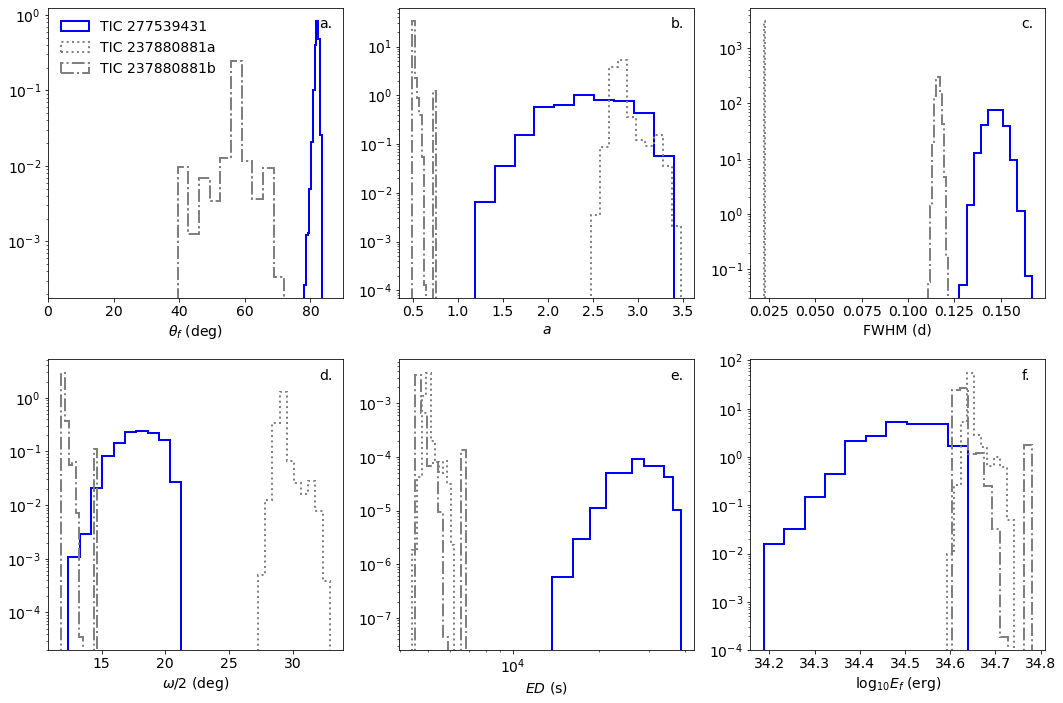

In [25]:
# Datasets we analysed
datasets = [(277539431, "", "08_07_2020_11_48"),
            (237880881, "a", "11_02_2020_10_07"),
            (237880881, "b", "11_02_2020_10_07"),
            ]

columns = ["latitude_deg","a",
           "fwhm_d",#"i_deg","phase_deg","t0_d"
           "rad_rsun","ED_s","Eflare_erg"]

fig, axp = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
axes = [a for ax in axp for a in ax]

for dataset in range(3):
    # What dataset do you want to analyse?
    ID, suffix, tstamp = datasets[dataset]

    # Pick up the input parameters
    CWD = "/".join(os.getcwd().split("/")[:-2])
    inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
    inits = inits[(inits.ID == str(ID)+suffix) &
                  (inits.tstamp==tstamp)].iloc[0]

    qlum = inits.qlum_erg_s * u.erg / u.s
    Fth = inits.Fth * u.erg / u.cm**2 / u.s
    median = inits['median']
    R = inits.R_Rsun * R_sun
    prefix = props[props.ID == ID].iloc[0].prefix


    # Pick up the LC
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")

    # Load MCMC chain
    resultframe = pd.read_csv(f"{CWD}/analysis/results/mcmc/"
                              f"{tstamp}_{ID}{suffix}_converted_mcmc_sample.csv")
    resultframe.Eflare_erg = np.log10(resultframe.Eflare_erg) 
    old = resultframe.shape[1]

    if 'Unnamed: 0' in resultframe.columns:
        resultframe = resultframe.drop('Unnamed: 0', axis=1)

    choose = (outs.ID == str(ID)) & (outs.suffix == suffix)
    color, linestyle = outs[choose].color.iloc[0], outs[choose].linestyle.iloc[0]
    
    
    for ax, col in zip(axes, columns):
        ax.hist(resultframe[col].values, 
                histtype="step", linewidth=2, density=True,log=True,
                linestyle=linestyle, color=color,
                label=f"{prefix} {ID}{suffix}")
        
        
valout = [#("t0_d", r"$t_0$ (BJD)"),
          ("latitude_deg", r"$\theta_f$ (deg)"),
          ("a",r"$a$"),
          ("fwhm_d", r"FWHM (d)"),
          #("i_deg",r"$i$ (deg)"),
          #("phase_deg",r"$\phi_0$ (deg)"),
          ("rad_rsun", r"$\omega/2$ (deg)"),
          ("ED_s", r"$ED$ (s)"),
          ("Eflare_erg",r"$\log_{10} E_{f}$ (erg)"),
          ]       

for ax, col, lab in zip(axes, valout, "abcdef"):
    colb, colp = col
    ax.set_xlabel(colp)
    if colb in ["ED_s"]:
        ax.set_xscale("log")
    if colb in ["latitude_deg", "i_deg"]:
        ax.set_xlim(0,90)
    ax.text(0.92, 0.92, f"{lab}.", horizontalalignment='left',fontsize=14,
                         verticalalignment='bottom', transform=ax.transAxes)
axes[0].legend(loc=2,frameon=False)
plt.tight_layout()

plt.savefig(f"{CWD}/analysis/plots/mcmc/all_together/{tstamp}_posteriors.png",dpi=300)